In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 22 17:25:13 2016

@author: tabacof
"""

# Implements a variational autoencoder as described in Kingma et al. 2013
# "Auto-Encoding Variational Bayes"
import theano
theano.config.floatX = 'float32'
import theano.tensor as T
import numpy as np
import lasagne
import time, shutil, os
import scipy
from scipy.io import loadmat
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import pylab as plt
from read_write_model import read_model, write_model

Using gpu device 1: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [2]:
#settings
do_train_model = False
batch_size = 100
num_epochs = 50
model_filename = "svhn_conv_clf"

np.random.seed(1234) # reproducibility

In [3]:
print "Using SVHN dataset"

svhn_train = loadmat('train_32x32.mat')
svhn_test = loadmat('test_32x32.mat')

train_y = svhn_train['y'].flatten() - 1
test_y = svhn_test['y'].flatten() - 1

train_x = np.rollaxis(svhn_train['X'].copy(), 3).transpose(0,3,1,2).astype(theano.config.floatX)
test_x = np.rollaxis(svhn_test['X'].copy(), 3).transpose(0,3,1,2).astype(theano.config.floatX)

svhn_mean = 115.11177966923525
svhn_std = 50.819267906232888
train_x = (train_x - svhn_mean)/svhn_std
test_x = (test_x - svhn_mean)/svhn_std

input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

Using SVHN dataset


In [4]:
relu = lasagne.nonlinearities.rectify

network = lasagne.layers.InputLayer(shape=(None, 3, 32, 32),input_var=input_var)
l_noise = lasagne.layers.BiasLayer(network, b = np.zeros((3,32,32), dtype = np.float32), shared_axes = 0, name = "NOISE")
l_noise.params[l_noise.b].remove("trainable")
network = lasagne.layers.Conv2DLayer(l_noise, num_filters=32, filter_size=(3, 3), nonlinearity=relu, pad = 'same')
network = lasagne.layers.Conv2DLayer(network, num_filters=32, filter_size=(3, 3), nonlinearity=relu)
network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
network = lasagne.layers.dropout(network, p=.25)
network = lasagne.layers.Conv2DLayer(network, num_filters=64, filter_size=(3, 3), nonlinearity=relu, pad = 'same')
network = lasagne.layers.Conv2DLayer(network, num_filters=32, filter_size=(3, 3), nonlinearity=relu)
network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
network = lasagne.layers.dropout(network, p=.25)
network = lasagne.layers.DenseLayer(network, num_units=512, nonlinearity=relu)
network = lasagne.layers.dropout(network, p=.5)
network = lasagne.layers.DenseLayer(network, num_units=10, nonlinearity=lasagne.nonlinearities.softmax)

In [5]:
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, 0.01, 0.9)

test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)
test_loss = test_loss.mean()
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

train_fn = theano.function([input_var, target_var], loss, updates=updates)

val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

In [6]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [7]:
if do_train_model:
    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(train_x, train_y, batch_size, shuffle=True):
            tr_inputs, tr_targets = batch
            train_err += train_fn(tr_inputs, tr_targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(test_x, test_y, batch_size, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))
    write_model([network], model_filename)
else:
    read_model([network], model_filename)

In [8]:
def show_svhn(img, i, title=""): # expects flattened image of shape (3072,) 
    img = img.copy().reshape(3,32,32).transpose(1,2,0)
    img *= svhn_std
    img += svhn_mean
    img /= 255.0
    img = np.clip(img, 0, 1)
    plt.subplot(1, 2, i)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [9]:
# Adversarial confusion cost function
adv_confusion = lasagne.objectives.categorical_crossentropy(test_prediction, target_var).mean()

# Adversarial regularization
regC = T.scalar()
adv_reg = regC*lasagne.regularization.l2(l_noise.b)
# Total adversarial loss
adv_loss = adv_confusion + adv_reg
adv_grad = T.grad(adv_loss, l_noise.b)

# Function used to optimize the adversarial noise
adv_function = theano.function([input_var, target_var, regC], [adv_loss, adv_grad, test_prediction])

In [10]:
def adv_test(orig_img, adv_label, C, plot = True):
    # Set the adversarial noise to zero
    l_noise.b.set_value(np.zeros((3,32,32)).astype(np.float32))

    _, _, orig_pred = adv_function(test_x[orig_img][np.newaxis, :, :, :], [adv_label], C)

    # Initialize the adversarial noise for the optimization procedure
    l_noise.b.set_value(np.random.uniform(-1e-8, 1e-8, size=(3,32,32)).astype(np.float32))

    # Optimization function for L-BFGS-B
    def fmin_func(x):
        l_noise.b.set_value(x.reshape(3, 32, 32).astype(np.float32))
        f, g, _ = adv_function(test_x[orig_img][np.newaxis, :, :, :], [adv_label], C)
        return float(f), g.flatten().astype(np.float64)

    # Noise bounds (pixels cannot exceed 0-1)
    bounds = zip(-svhn_mean/svhn_std-test_x[orig_img].flatten(), (255.0-svhn_mean)/svhn_std-test_x[orig_img].flatten())

    # L-BFGS-B optimization to find adversarial noise
    x, f, d = scipy.optimize.fmin_l_bfgs_b(fmin_func, l_noise.b.get_value().flatten(), bounds = bounds, fprime = None, factr = 10, m = 25)
    l_noise.b.set_value(x.reshape(3, 32, 32).astype(np.float32))
    
    adv_loss, _, adv_pred = adv_function(test_x[orig_img][np.newaxis, :, :, :], [adv_label], C)

    if plot:
        plt.figure()
        show_svhn(test_x[orig_img], 1, "Original")
        show_svhn(test_x[orig_img] + x.reshape(3, 32, 32), 2, "Adversarial")
        plt.show()
            
    return adv_loss, np.linalg.norm(x), test_y[orig_img], np.argmax(orig_pred), np.argmax(adv_pred), adv_pred[0][test_y[orig_img]], adv_pred[0][adv_label]

In [17]:
def orig_adv_dist(orig_img = None, plot = False):
    if orig_img is None:
        orig_img = np.random.randint(0, len(test_x))
        _, _, pred = adv_function(test_x[orig_img][np.newaxis, :], [0], 0.0)
        print(np.argmax(pred), test_y[orig_img], pred)
        while np.argmax(pred) != test_y[orig_img]:
            orig_img = np.random.randint(0, len(test_x))
            _, _, pred = adv_function(test_x[orig_img][np.newaxis, :], [0], 0.0)
            print(np.argmax(pred), test_y[orig_img], pred)

    adv_label = test_y[orig_img]
    while adv_label ==  test_y[orig_img]:
        adv_label = np.random.randint(0, 10)
        
    print "Img",orig_img, "Adv label", adv_label
    
    adv_loss=[]
    adv_norm=[]
    orig_prob=[]
    adv_prob=[]
    adv = []
    
    C = np.logspace(-10, 20, 50, base = 2, dtype = np.float32)
    plot_intersection = plot
    
    for i, c in enumerate(C):
        plot_current = plot and (i == 0 or i == 49)
        od, ad, ol, op, ap, o_prob, a_prob = adv_test(orig_img, adv_label, C=c, plot = plot_current)
        if plot_current:
            print ad, o_prob, a_prob
        if plot_intersection and o_prob >= a_prob:
            adv_test(orig_img, adv_label, C=C[i-1], plot = True)
            plot_intersection = False
            print ad, o_prob, a_prob
        adv_loss.append(od)
        adv_norm.append(ad)
        adv.append(ap == adv_label)
        orig_prob.append(o_prob)
        adv_prob.append(a_prob)
        
    adv_loss = np.array(adv_loss)
    adv_norm = np.array(adv_norm)

    if plot:
        plt.figure()
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [adv_loss[i] for i, x in enumerate(adv) if x], c='red', label = "Adversarial")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [adv_loss[i] for i, x in enumerate(adv) if not x], c='blue', label = "Non-adversarial")
        plt.ylabel("Adversarial cross-entropy")
        plt.xlabel("Adversarial distortion")
        plt.legend(loc=3, prop={'size':9})
        plt.show()
        plt.figure()
        plt.scatter(adv_norm, adv_prob, c='red', label = "Adversarial")
        plt.scatter(adv_norm, orig_prob, c='blue', label = "Original")
        #plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [adv_prob[i] for i, x in enumerate(adv) if x], c='orange', label = "Adversarial Adv")
        #plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [adv_prob[i] for i, x in enumerate(adv) if not x], c='cyan', label = "Non-adversarial Adv")
        #plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [orig_prob[i] for i, x in enumerate(adv) if x], c='red', label = "Adversarial Orig")
        #plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [orig_prob[i] for i, x in enumerate(adv) if not x], c='blue', label = "Non-adversarial Orig")
        plt.ylabel("Probability")
        plt.xlabel("Adversarial distortion")
        plt.legend(loc=3, prop={'size':9})
        plt.show()
        plt.figure()
        plt.scatter(adv_norm, scipy.special.logit(adv_prob), c='red', label = "Adversarial")
        plt.scatter(adv_norm, scipy.special.logit(orig_prob), c='blue', label = "Original")
        #plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [scipy.special.logit(adv_prob[i]) for i, x in enumerate(adv) if x], c='orange', label = "Adversarial Adv")
        #plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [scipy.special.logit(adv_prob[i]) for i, x in enumerate(adv) if not x], c='cyan', label = "Non-adversarial Adv")
        #plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [scipy.special.logit(orig_prob[i]) for i, x in enumerate(adv) if x], c='red', label = "Adversarial Orig")
        #plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [scipy.special.logit(orig_prob[i]) for i, x in enumerate(adv) if not x], c='blue', label = "Non-adversarial Orig")
        plt.ylabel("Logit")
        plt.xlabel("Adversarial distortion")
        plt.legend(loc=3, prop={'size':9})
        plt.show()
        
    return adv_norm, adv_loss, adv_prob, orig_prob

(4, 4, array([[  1.93444848e-05,   1.19140316e-06,   9.09991271e-04,
          6.98356016e-05,   9.97536421e-01,   5.72663121e-05,
          6.50037251e-08,   5.15180091e-06,   1.40074873e-03,
          3.19260316e-08]], dtype=float32))
Img 571 Adv label 9


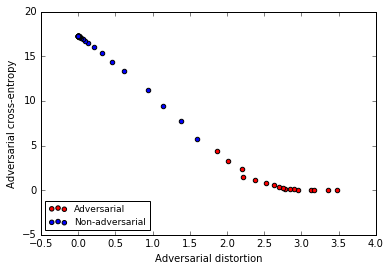

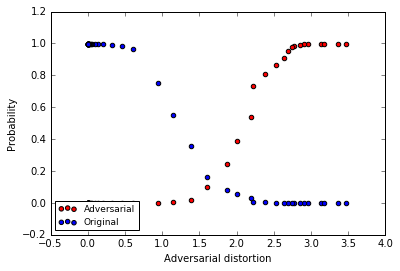

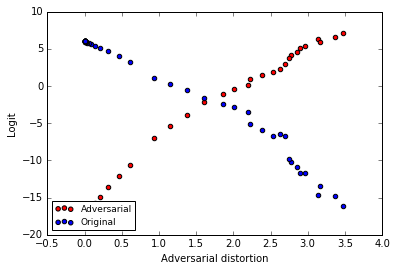

(0, 0, array([[  9.99724090e-01,   6.68888533e-05,   8.98685321e-05,
          3.37247111e-05,   1.20849336e-06,   2.07059588e-06,
          3.04007863e-05,   3.74433039e-05,   1.65234496e-06,
          1.27700059e-05]], dtype=float32))
Img 21449 Adv label 4


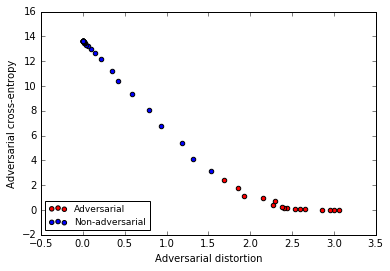

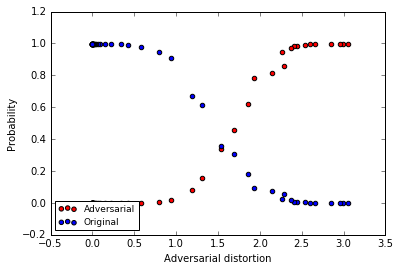

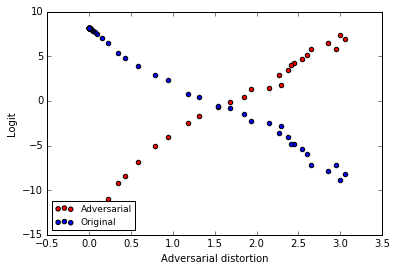

(8, 4, array([[  3.93273029e-03,   2.89973244e-02,   2.51498241e-02,
          6.50814909e-04,   1.02118678e-01,   3.89541347e-05,
          9.13528502e-02,   1.16373785e-05,   7.47727752e-01,
          1.93942269e-05]], dtype=float32))
(7, 7, array([[  9.06755496e-03,   4.27601021e-03,   1.90523956e-02,
          5.28541617e-02,   2.28911228e-02,   5.49671464e-02,
          6.89190114e-04,   8.08312893e-01,   2.53052954e-02,
          2.58435588e-03]], dtype=float32))
Img 11273 Adv label 6


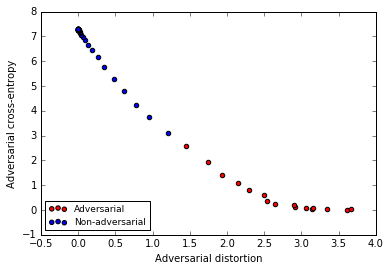

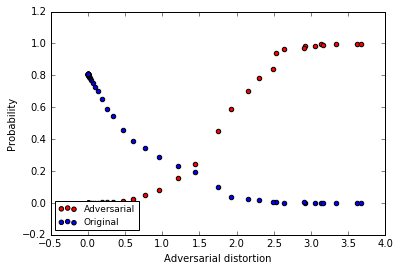

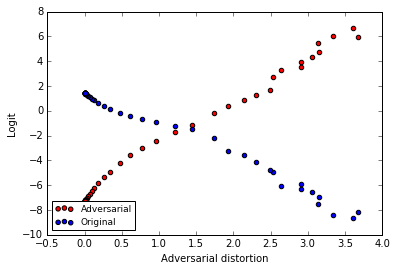

(1, 1, array([[  1.92770004e-01,   4.41824377e-01,   1.23791568e-01,
          1.16437692e-02,   3.00908927e-02,   2.72979718e-02,
          1.60091490e-01,   2.26903125e-03,   1.00716632e-02,
          1.49199273e-04]], dtype=float32))
Img 14077 Adv label 0


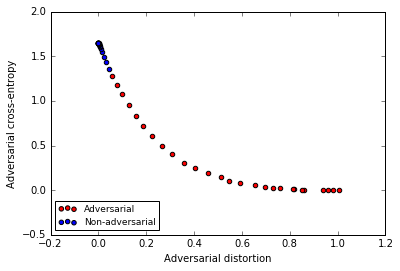

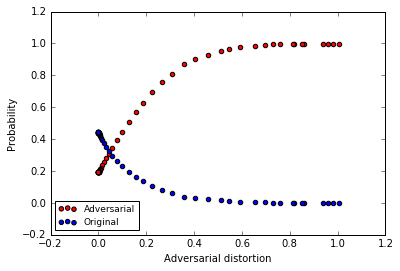

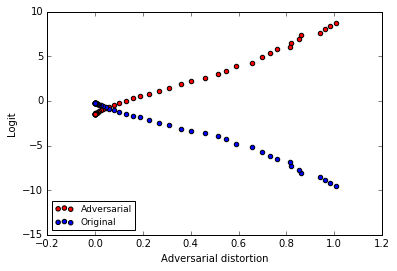

(2, 2, array([[  1.04883147e-04,   1.33991463e-03,   9.98493195e-01,
          3.16817841e-06,   1.97690724e-07,   1.86533441e-07,
          4.96343091e-06,   4.86355784e-05,   4.43147883e-06,
          2.56365695e-07]], dtype=float32))
Img 24484 Adv label 4


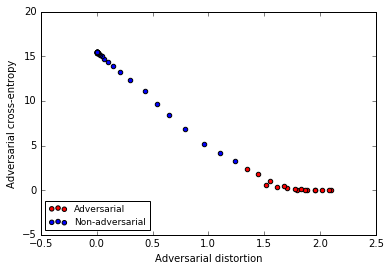

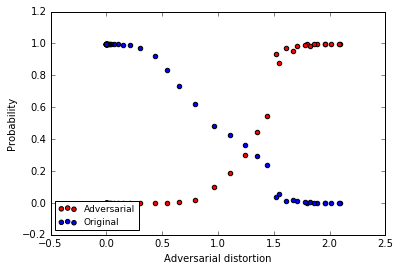

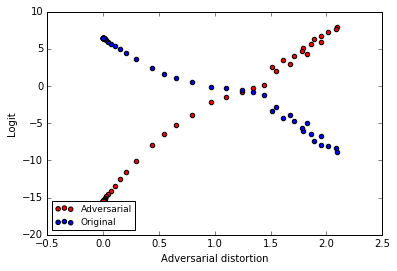

(1, 1, array([[  6.25126673e-10,   1.00000000e+00,   1.10395670e-09,
          8.04760217e-11,   9.20439350e-11,   1.71446034e-11,
          1.01141109e-10,   5.10607789e-12,   2.94514901e-09,
          2.63275379e-09]], dtype=float32))
Img 7521 Adv label 4


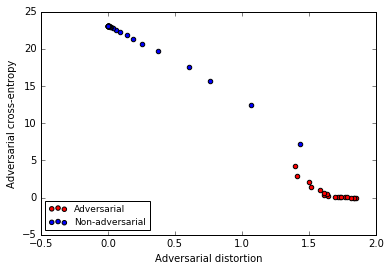

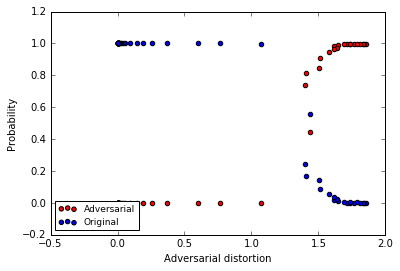

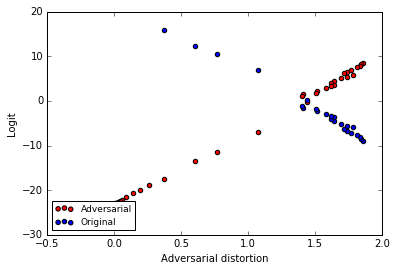

(4, 4, array([[  3.94306517e-06,   8.78645778e-09,   3.61408659e-09,
          7.53936524e-10,   9.99992371e-01,   1.29994220e-08,
          3.52641405e-06,   1.44888546e-10,   9.88576190e-08,
          4.56417022e-11]], dtype=float32))
Img 9060 Adv label 5


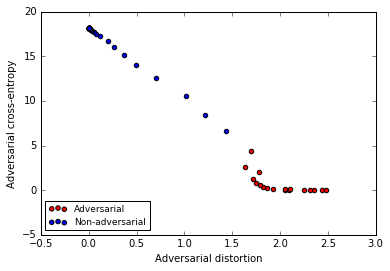

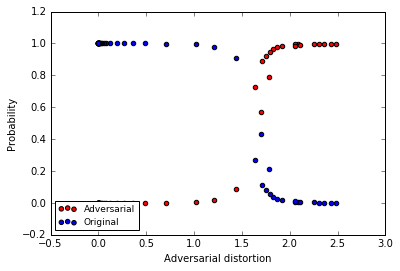

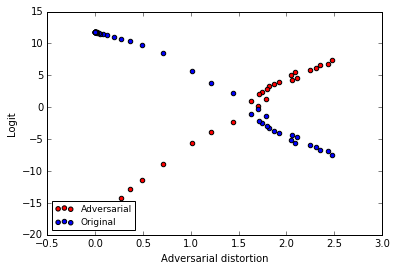

(7, 2, array([[ 0.01652412,  0.00491087,  0.21809815,  0.00564381,  0.05065867,
         0.05598068,  0.00221974,  0.39466619,  0.12670167,  0.12459612]], dtype=float32))
(3, 3, array([[  5.89336960e-05,   3.80211418e-06,   2.40645045e-03,
          9.97456849e-01,   2.07182438e-06,   9.79330750e-09,
          7.16985960e-05,   1.23113442e-09,   2.25267726e-07,
          1.25943755e-10]], dtype=float32))
Img 15840 Adv label 7


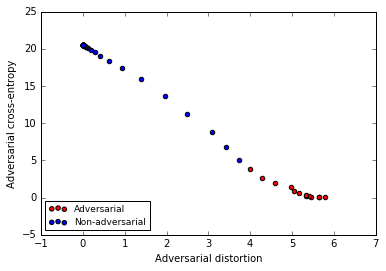

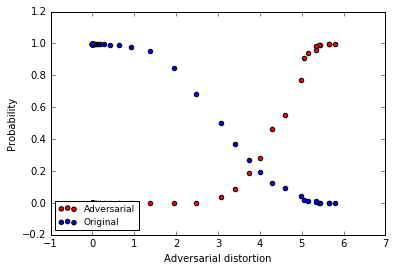

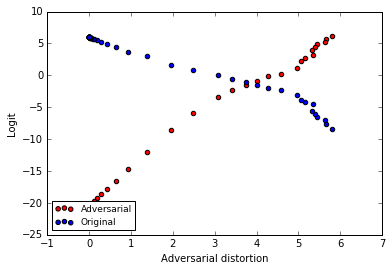

(3, 3, array([[  8.08479163e-05,   1.98239184e-04,   1.04061844e-04,
          9.98980701e-01,   4.05227956e-06,   2.06038658e-06,
          1.22969243e-04,   6.22470689e-05,   4.44587437e-04,
          1.96106257e-07]], dtype=float32))
Img 14110 Adv label 5


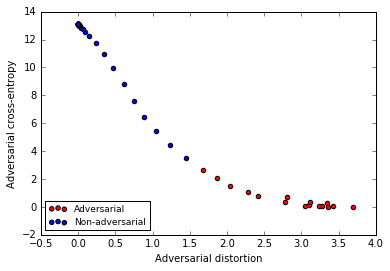

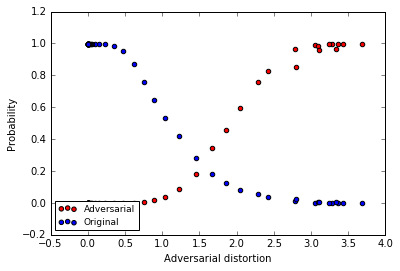

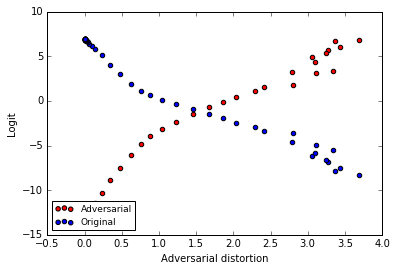

(5, 5, array([[  2.48186915e-09,   3.15164735e-11,   1.73129316e-10,
          1.02613542e-13,   2.60122644e-04,   9.99739826e-01,
          8.93027111e-11,   3.01404790e-09,   1.64522812e-12,
          1.24399813e-09]], dtype=float32))
Img 25804 Adv label 1


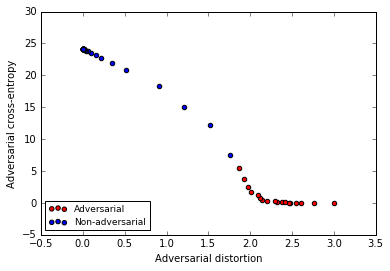

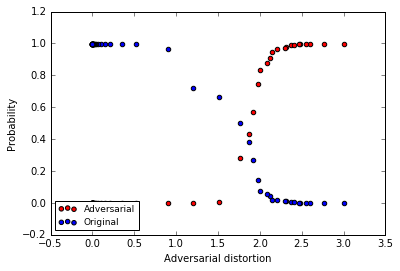

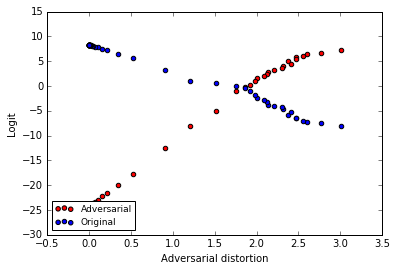

(2, 2, array([[  1.00247405e-06,   3.25288028e-08,   9.99998569e-01,
          7.15111248e-10,   4.08353799e-07,   1.02181363e-09,
          2.19014105e-08,   5.00357888e-09,   3.92059246e-10,
          1.04083782e-08]], dtype=float32))
Img 17557 Adv label 3


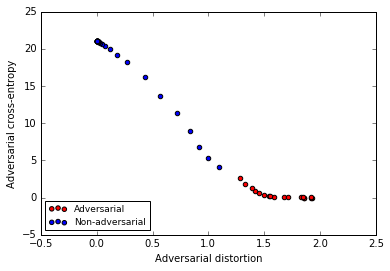

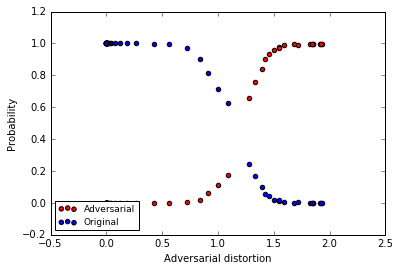

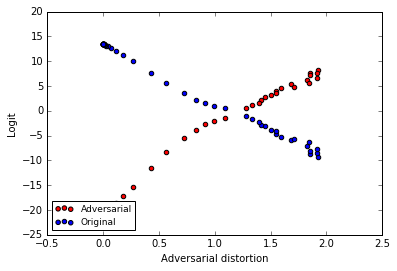

(0, 0, array([[  9.99997497e-01,   2.34943496e-08,   2.22974677e-06,
          1.57409076e-07,   7.81024028e-08,   4.50503468e-10,
          2.59358143e-11,   2.88216295e-09,   4.86099205e-09,
          2.92189168e-12]], dtype=float32))
Img 25632 Adv label 5


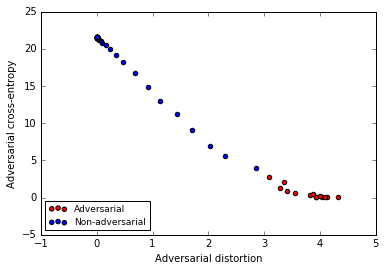

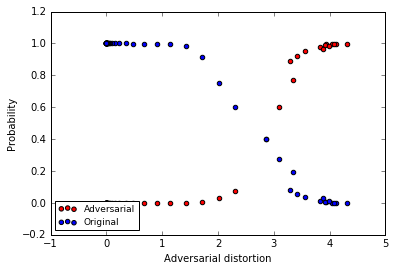

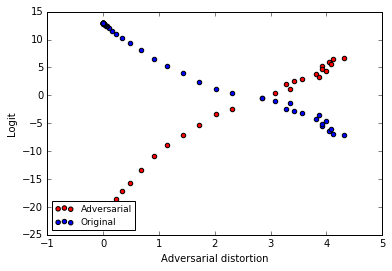

(0, 0, array([[  9.96883929e-01,   7.62832940e-07,   8.30073441e-06,
          3.10029229e-03,   2.08910986e-08,   3.78090341e-08,
          5.08929770e-06,   2.55359680e-07,   3.93677340e-07,
          1.03626064e-06]], dtype=float32))
Img 16666 Adv label 6


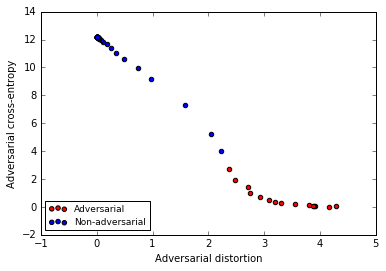

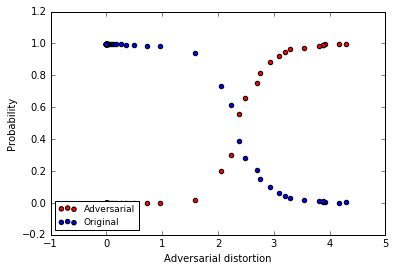

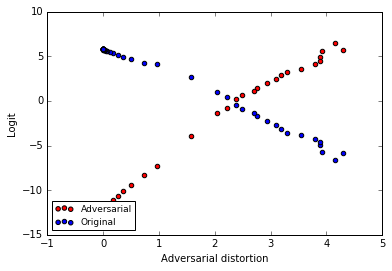

(6, 6, array([[  3.45720910e-02,   8.71262455e-04,   6.52196109e-02,
          9.93399808e-05,   1.78523757e-03,   1.02325881e-04,
          8.83706510e-01,   1.21260271e-03,   1.07963979e-02,
          1.63450302e-03]], dtype=float32))
Img 19943 Adv label 1


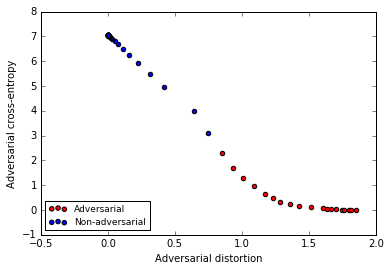

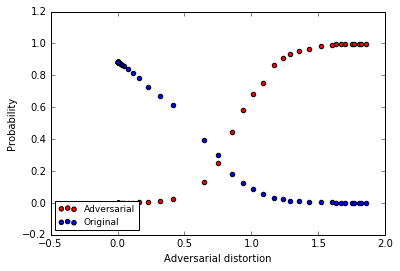

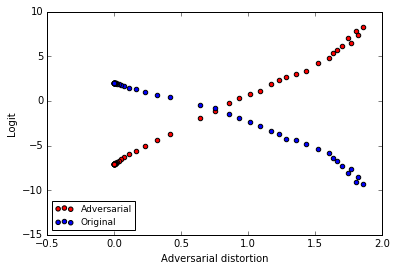

(3, 3, array([[  7.06129276e-06,   1.76015888e-07,   3.90694060e-10,
          9.99992728e-01,   2.61342539e-08,   1.15786820e-08,
          5.27217103e-10,   2.61204773e-11,   1.01848718e-09,
          1.99672345e-11]], dtype=float32))
Img 8667 Adv label 7


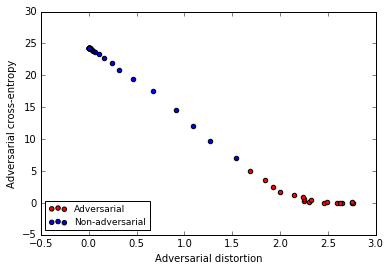

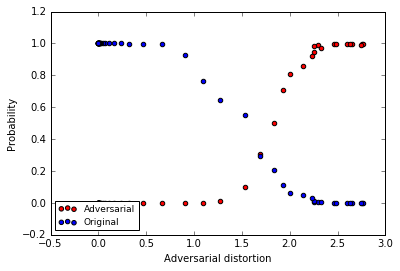

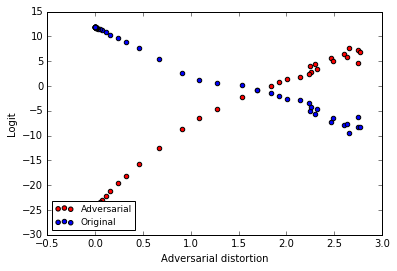

(0, 0, array([[  9.63681102e-01,   1.99813326e-03,   1.83816087e-06,
          2.43968070e-02,   2.74778926e-04,   7.92077556e-03,
          1.66928954e-03,   5.17246481e-05,   3.60890704e-06,
          2.11034080e-06]], dtype=float32))
Img 21665 Adv label 7


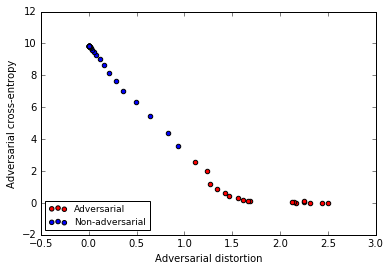

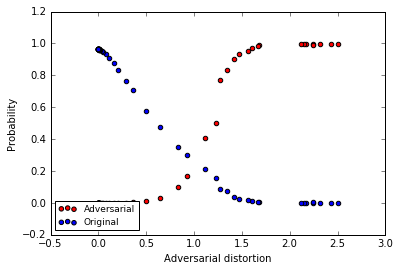

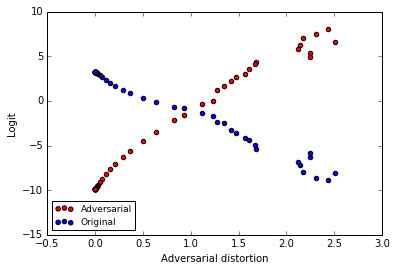

(1, 2, array([[  1.16185639e-02,   9.40757215e-01,   4.98363655e-03,
          6.80898840e-04,   1.46765351e-05,   3.37651290e-05,
          1.22304000e-02,   7.60952127e-04,   2.71526240e-02,
          1.76743814e-03]], dtype=float32))
(2, 2, array([[  5.63000549e-06,   1.65376559e-06,   9.99803424e-01,
          5.33239131e-07,   3.12985139e-05,   9.56315944e-07,
          1.59307376e-07,   1.27227453e-04,   2.58948512e-05,
          3.39132566e-06]], dtype=float32))
Img 21387 Adv label 1


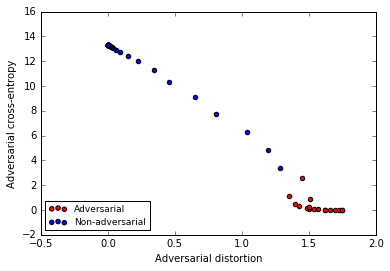

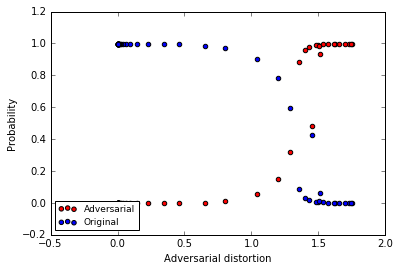

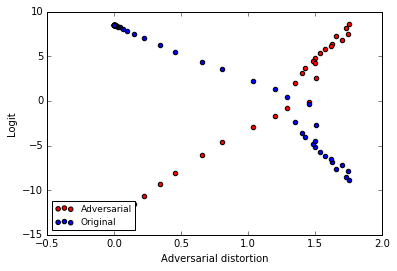

(4, 4, array([[  1.45127324e-05,   1.73667706e-06,   9.28564649e-03,
          3.77940637e-06,   9.82885599e-01,   1.06028465e-05,
          1.33248011e-06,   1.17798900e-05,   7.78512005e-03,
          5.22706074e-08]], dtype=float32))
Img 13190 Adv label 8


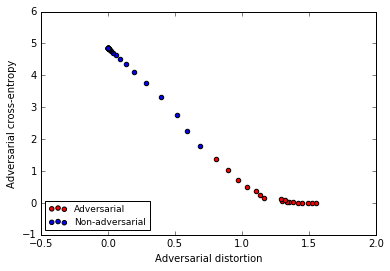

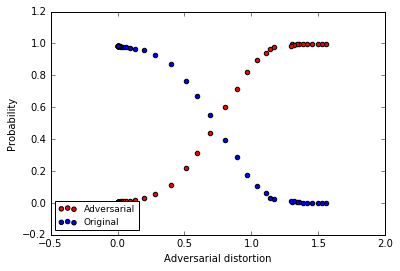

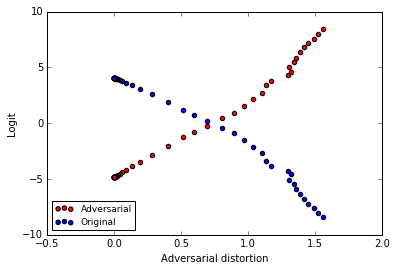

(0, 0, array([[  9.99977469e-01,   2.81731758e-07,   1.55275552e-06,
          2.28567092e-06,   3.56684012e-07,   3.82048114e-07,
          1.73658082e-05,   8.82908502e-09,   3.91478096e-07,
          5.80592356e-08]], dtype=float32))
Img 4095 Adv label 2


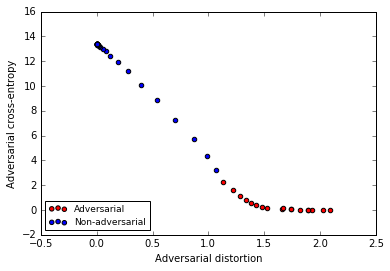

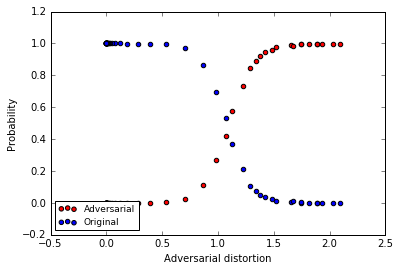

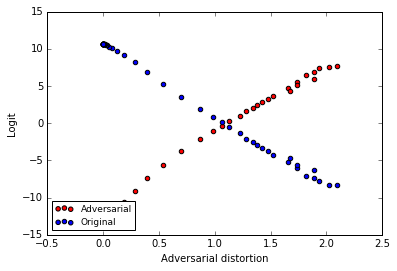

(5, 5, array([[  2.83781173e-15,   6.04282656e-14,   3.39853805e-11,
          2.14801434e-17,   1.24874830e-08,   1.00000000e+00,
          6.49543411e-18,   2.95980618e-09,   9.69916087e-18,
          9.16328194e-11]], dtype=float32))
Img 4919 Adv label 8


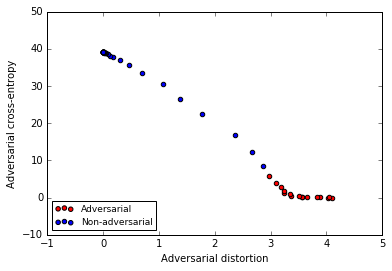

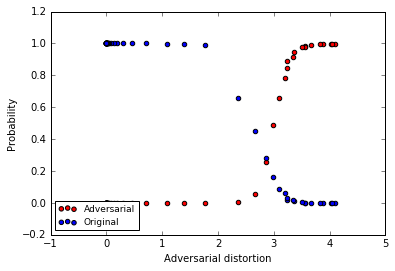

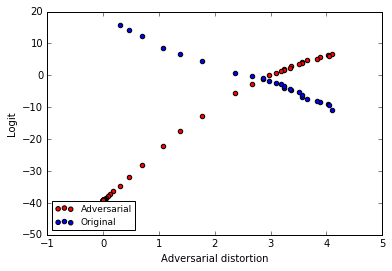

(1, 1, array([[  6.26699328e-02,   5.82742989e-01,   2.29657605e-01,
          1.19561665e-02,   1.37817202e-04,   4.88709629e-05,
          1.06284395e-01,   6.18510786e-03,   2.81623681e-04,
          3.55406628e-05]], dtype=float32))
Img 3738 Adv label 3


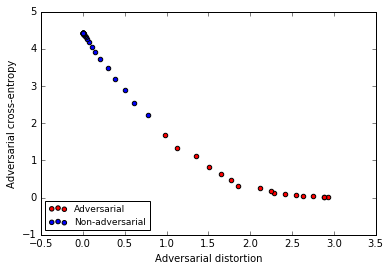

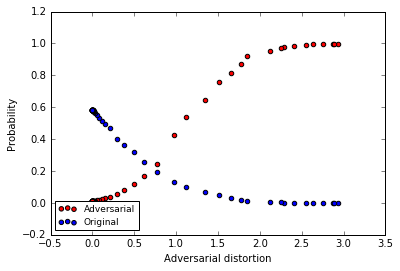

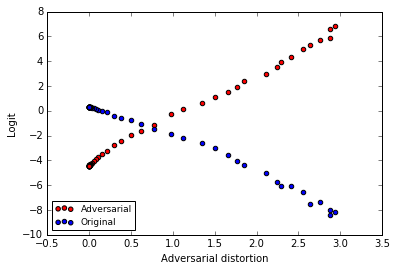

(9, 9, array([[  5.93101745e-09,   9.76862258e-10,   9.96418897e-15,
          1.01116103e-11,   1.86985996e-15,   1.50590831e-10,
          1.86205455e-15,   4.25452251e-09,   1.19273437e-07,
          9.99999881e-01]], dtype=float32))
Img 16208 Adv label 7


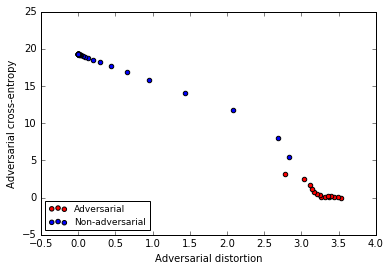

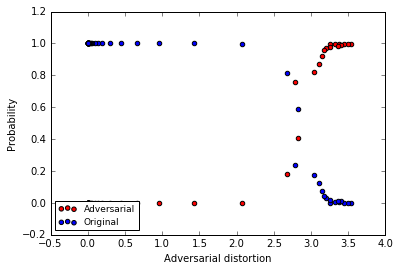

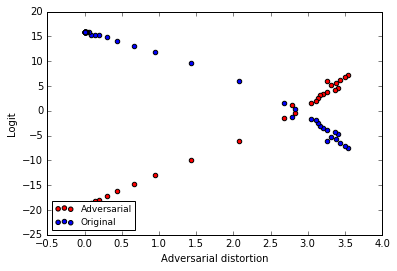

(3, 3, array([[  9.95430938e-08,   2.17691393e-10,   9.39689368e-11,
          9.99999881e-01,   8.17122481e-10,   4.61210063e-13,
          2.76403228e-12,   2.16433052e-11,   5.07646702e-10,
          2.38207196e-14]], dtype=float32))
Img 6753 Adv label 0


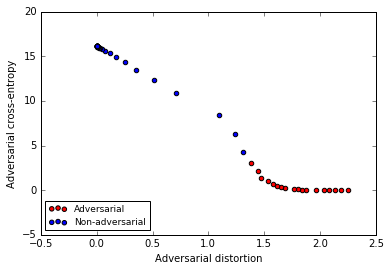

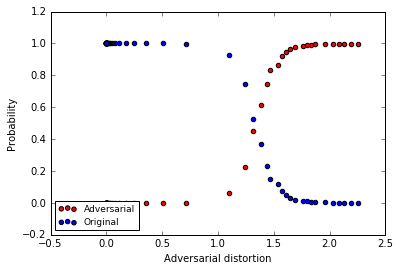

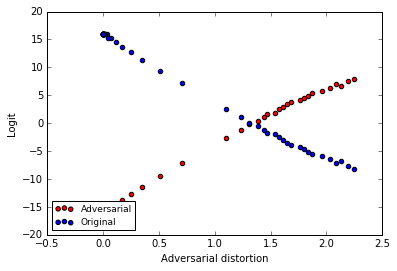

(1, 1, array([[  1.71073694e-07,   9.99999523e-01,   1.36413121e-07,
          7.54114371e-09,   4.35048868e-08,   1.95003835e-07,
          1.67797276e-10,   5.28901756e-10,   1.82994869e-10,
          1.58676861e-09]], dtype=float32))
Img 18703 Adv label 8


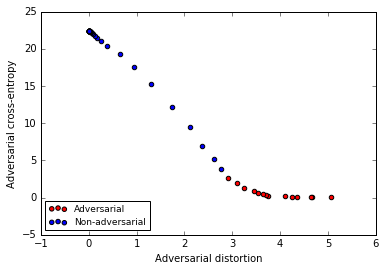

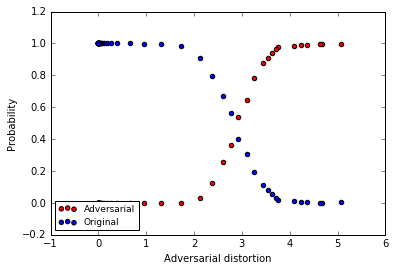

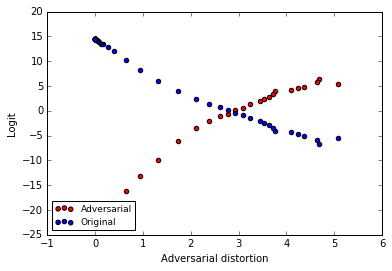

(3, 3, array([[  1.11103910e-12,   4.98904970e-18,   1.41061103e-22,
          1.00000000e+00,   7.79814131e-19,   2.48074177e-23,
          5.84214041e-23,   1.93111730e-23,   1.95029816e-17,
          9.39142482e-26]], dtype=float32))
Img 25937 Adv label 4


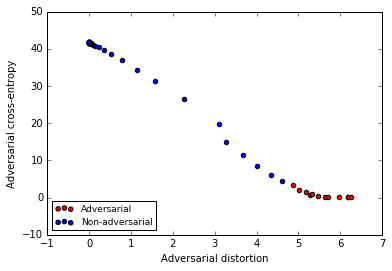

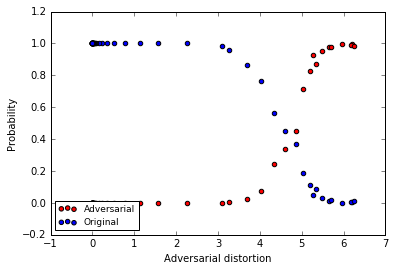

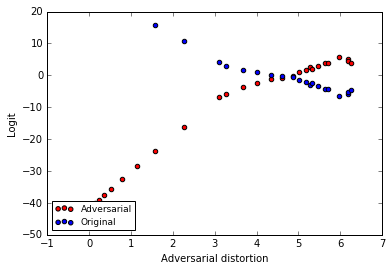

In [12]:
n = 25

adv_norm = []
adv_prob = []
orig_prob = []

for i in range(n):
    an, _, ap, op = orig_adv_dist(plot = True)
    adv_norm.append(an)
    adv_prob.append(ap)
    orig_prob.append(op)
    
adv_norm = np.array(adv_norm)
adv_prob = np.array(adv_prob)
adv_prob_logit = scipy.special.logit(adv_prob)
orig_prob = np.array(orig_prob)
orig_prob_logit = scipy.special.logit(orig_prob)

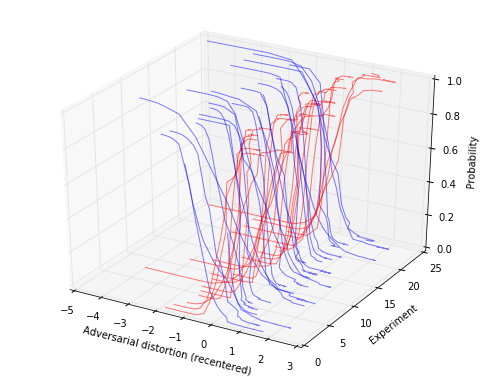

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(n):
    intersection = np.argmax((orig_prob[i] - adv_prob[i]) >= 0)
    intersection_x = (adv_norm[i][intersection-1] + adv_norm[i][intersection])/2.0
    intersection_y1 = 0#(adv_prob[i][intersection-1] + adv_prob[i][intersection])/2.0
    intersection_y2 = 0#(orig_prob[i][intersection-1] + orig_prob[i][intersection])/2.0
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), adv_prob[i]-intersection_y1, color = 'r', alpha = 0.5)
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), orig_prob[i]-intersection_y2, color = 'b', alpha = 0.5)

ax.set_xlabel('Adversarial distortion (recentered)')
ax.set_ylabel('Experiment')
ax.set_zlabel('Probability')
fig.set_figwidth(8.5)
fig.set_figheight(6.5)
plt.show()

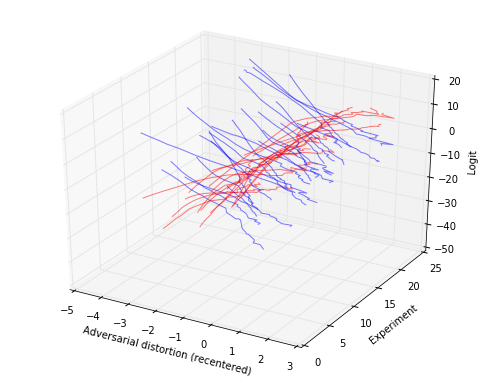

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(n):
    intersection = np.argmax((orig_prob_logit[i] - adv_prob_logit[i]) >= 0)
    intersection_x = (adv_norm[i][intersection-1] + adv_norm[i][intersection])/2.0
    intersection_y1 = 0#(adv_prob_logit[i][intersection-1] + adv_prob_logit[i][intersection])/2.0
    intersection_y2 = 0#(orig_prob_logit[i][intersection-1] + orig_prob_logit[i][intersection])/2.0
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), adv_prob_logit[i]-intersection_y1, color = 'r', alpha = 0.5)
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), orig_prob_logit[i]-intersection_y2, color = 'b', alpha = 0.5)

ax.set_xlabel('Adversarial distortion (recentered)')
ax.set_ylabel('Experiment')
ax.set_zlabel('Logit')
fig.set_figwidth(8.5)
fig.set_figheight(6.5)
plt.show()

(3, 3, array([[  2.11398255e-05,   2.07760022e-03,   1.10851843e-05,
          9.96081471e-01,   1.61356421e-03,   1.16160874e-04,
          3.52212737e-06,   1.55962171e-05,   5.80744490e-05,
          1.80572715e-06]], dtype=float32))
Img 17866 Adv label 5


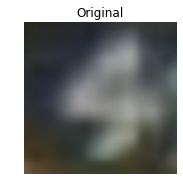

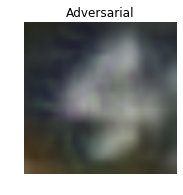

3.34656220403 0.000439284 0.998796


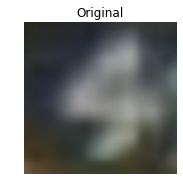

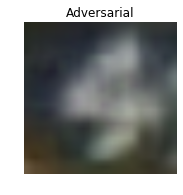

1.55016183443 0.409804 0.36813


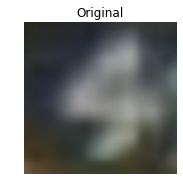

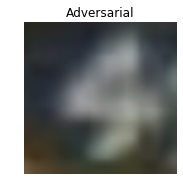

3.98505685643e-06 0.996081 0.000116165


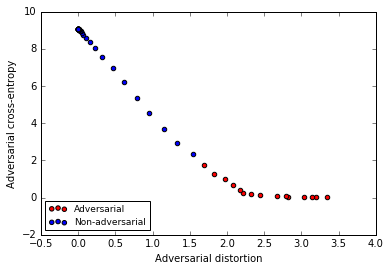

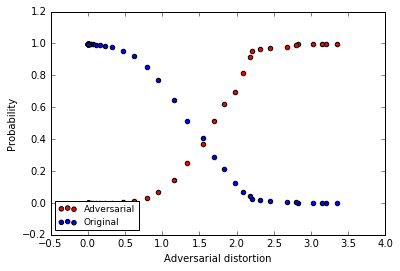

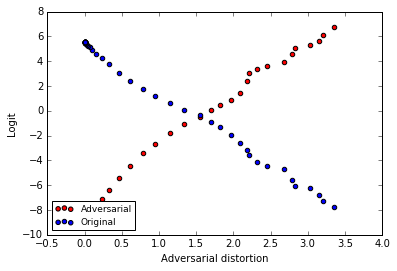

In [19]:
_, _, _, _ =orig_adv_dist(plot = True)